<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #3: ARIMAX, Compositions

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

**Дополнительный материал для выполнения дз**:
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

<span style="color:red; font-size: 14pt;"> DEADLINE: 10 October 2017 23:59:59 </span>

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 


<h1 align="center">Check Questions (20%)</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1** Опишите ситуацию (аргументированно), в котором композиция Adaptive Selection будет прогнозировать хуже, чем лучший из базовых алгоритмов.

<Ответ>

**Вопрос 2**  Опишите ситуацию (аргументированно), в котором композиция Adaptive Composition будет прогнозировать хуже, чем лучший из базовых алгоритмов.

<Ответ>

**Вопрос 3** Что значит смешиваемость (mixability) игры (в теории агрегирующего алгоритма)?

<Ответ>

**Вопрос 4**: Верно ли, что для смешиваемых игр процесс потерь любой композиции (любого алгоритма) будет расти со временем (с ростом $t$) не быстрее, чем процесс потерь лучшего из базовых алгоритмов? Если нет - приведит пример, когда это не так.

### $$ \mathrm{Loss}_{Composition}(T)\leq \inf\limits_{BA} \mathrm{Loss}_{BA}(T)+C$$

<Ответ>

<h1 align="center">2. Contest: electricity comsumption contest (80%)</h1>
Take part in <a href='https://www.kaggle.com/t/de102b28cae74e6ead7492ff12efbc63'>contest</a>.
<span style='color:red'> You need to send the final code that is used for building forecast.</span>

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [157]:
import os

!ls ../../data/electricity
data_path = '../../data/electricity/'
train_path = os.path.join(data_path, 'train.csv')
sample_path = os.path.join(data_path, 'SubmissionSample.csv')

raw_data = []
with open(train_path) as fin:
    raw_data = pd.read_csv(fin, verbose=True)

SubmissionSample.csv  train.csv
Tokenization took: 13.17 ms
Type conversion took: 9.29 ms
Parser memory cleanup took: 0.01 ms


In [158]:
def prepare_data(data):
    data.index = [np.int64(x) for x in data['ID']]
    data.drop(labels=['Date', 'tsID'], axis=1, inplace=True)
    data.dropna(inplace=True)

In [159]:
raw_data.head()

,ID,Date,tsID,ACTUAL,Temp,Saturday,Sunday
0,1,01.01.2010,4,35489.95,-0.9,0.0,1
1,2,02.01.2010,4,35413.59,-0.1,1.0,0
2,3,03.01.2010,4,34802.67,-3.9,0.0,1
3,4,04.01.2010,4,36003.84,-13.7,0.0,1
4,5,05.01.2010,4,37622.96,-16.9,0.0,1


In [160]:
ts_ids = set(raw_data.tsID)
raw_train_data = {}

for ts_id in ts_ids:
    raw_train_data[ts_id] = raw_data.where(raw_data.tsID == ts_id)
    prepare_data(raw_train_data[ts_id])

In [166]:
raw_train_data[1].head()

,ID,ACTUAL,Temp,Saturday,Sunday
15672,15672.0,90468.0,22.5,0.0,1.0
15673,15673.0,92764.0,20.0,1.0,0.0
15674,15674.0,94791.0,21.0,0.0,1.0
15675,15675.0,98010.0,16.8,0.0,1.0
15676,15676.0,100975.0,19.2,0.0,1.0


In [162]:
def series_to_supervised(data, n_in, n_out, target, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    tmp = df.drop(labels=target, axis=1)
    cols.append(tmp)
    names.extend(tmp.columns)
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df[target].shift(i))
        names += ['{}(t-{})'.format(target, i)]
    
    # forecast sequence (t+1, ... t+n)
    for i in range(1, n_out + 1):
        cols.append(df[target].shift(-i))
        names += ['{}(t+{})'.format(target, i)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg


def get_data(data, i):
    return data.iloc[:, 1:-30], data.iloc[:, -(31 - i)]


def mape(x, y):
    qlt = ((x - y).abs() / x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean()


def cross_validation(model, X, y, k=5, frac=0.8, metric=mape, verbose=False, plot=False):
    N = int(len(X) * frac)
    delta = (len(X) - N) // k
    
    score = 0.
    for i in range(k):
        n = int(N * frac)
        cv_x_train = X.iloc[i * delta:i * delta + n, :]
        cv_x_test = X.iloc[i * delta + n:i * delta + N, :]
        cv_y_train = y.iloc[i * delta:i * delta + n]
        cv_y_test = y.iloc[i * delta + n:i * delta + N]
        
        model.fit(cv_x_train, cv_y_train)
        
        cur_res = metric(cv_y_test, model.predict(cv_x_test))
        if verbose:
            print('fold {}, loss={}'.format(i, cur_res))
        score += cur_res
        
        if plot:
            plt.figure(figsize=(12, 8))
            plt.plot(cv_y_test.index, cv_y_test, 'b')
            plt.plot(cv_y_test.index, model.predict(cv_x_test), 'r')
            plt.show()
    
    return score / k

In [163]:
train_data = {}

for ts in raw_train_data:
    train_data[ts] = series_to_supervised(raw_train_data[ts], 30, 30, 'ACTUAL')

fold 0, loss=0.02791837656732018


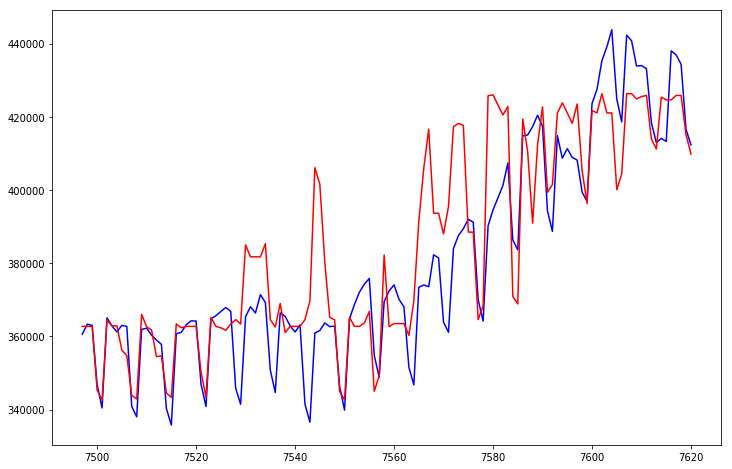

fold 1, loss=0.04136590316131293


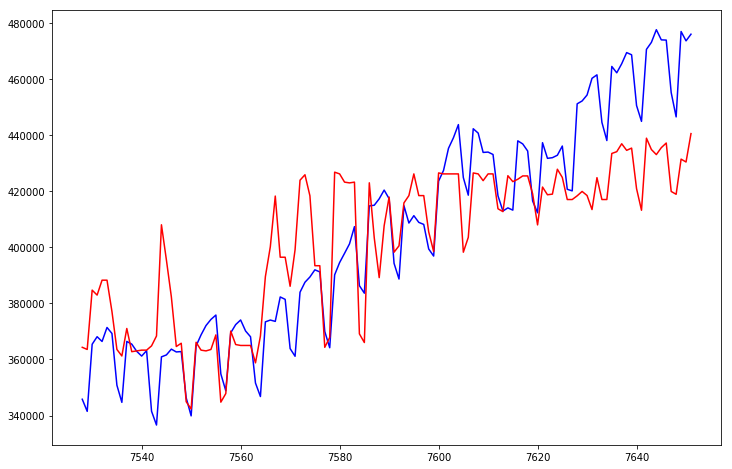

fold 2, loss=0.04311224945635763


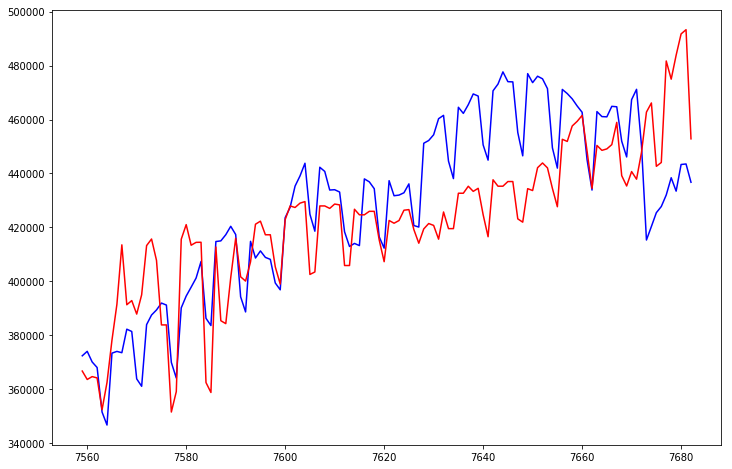

fold 3, loss=0.047867249001265835


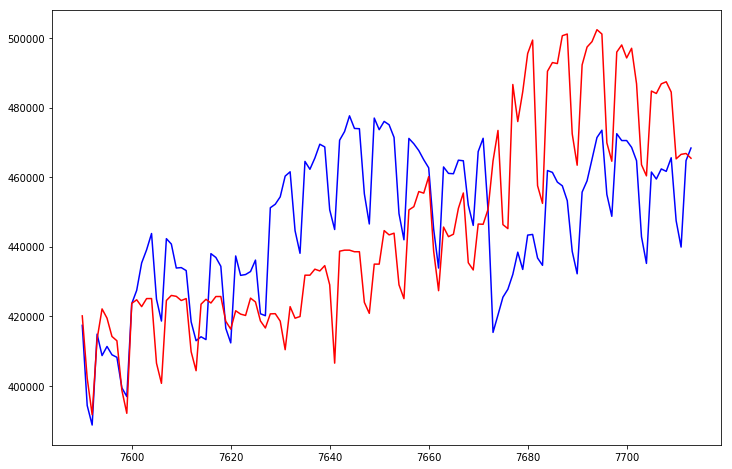

fold 4, loss=0.05153308457547058


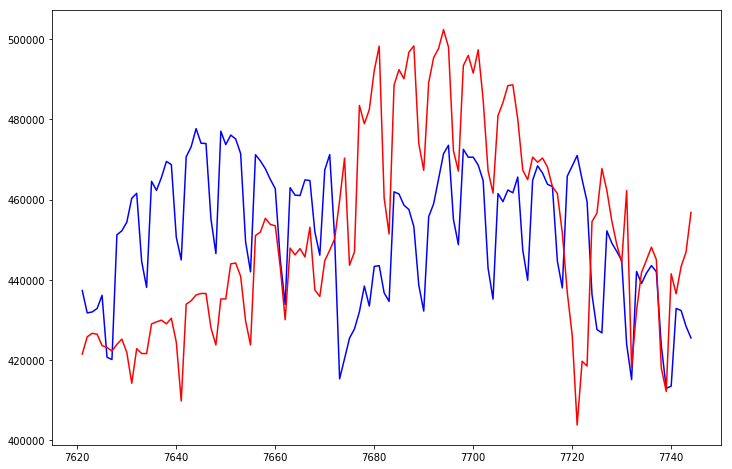

2 0.0423593725523


In [185]:
from xgboost import XGBRegressor

model = XGBRegressor(nthread=3, seed=501, max_depth=2)

X, y = get_data(data, 30)

print(2, cross_validation(model, X, y, verbose=True, plot=True))

In [103]:
XGBRegressor?

In [165]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=501, n_jobs=3, max_depth=10)

X, y = get_data(data, 1)

print(cross_validation(model, X, y, verbose=True))

fold 0, loss=0.012668990556568312
fold 1, loss=0.016714146636136594
fold 2, loss=0.017803674752853133
fold 3, loss=0.02393335837628128
fold 4, loss=0.025137578074668144
0.0192515496793


In [119]:
pd.DataFrame.max?

# Отправка

In [175]:
answers = {}

for ts, data in train_data.items():
    test_data = series_to_supervised(raw_train_data[ts], 30, 0, 'ACTUAL')
    models = []
    for i in range(1, 31):
        X, y = get_data(data, i)
        models.append(XGBRegressor(nthread=3, seed=501, max_depth=2))
        models[-1].fit(X, y)
    
    last = raw_train_data[ts].index.max()
    x = test_data.where(test_data.ID == last).drop(labels='ID', axis=1).dropna()
    
    for day in range(1, 31):
        answers[last + day] = models[day - 1].predict(x)[0]

In [179]:
len(answers)

660

In [176]:
with open(sample_path) as fin:
    raw_sample = pd.read_csv(fin)

In [178]:
raw_sample.shape

(660, 2)

In [183]:
with open('result.csv', 'w') as fout:
    print('ID,PREDICTED', file=fout)
    for idx, ans in answers.items():
        print(idx, ans, sep=',', file=fout)